In [1]:
import sqlite3
import pandas as pd
import numpy as np
import xlrd
import os
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import iqr

# ETL

In [2]:
#extract data from excel file

with pd.ExcelFile(r"C:\Users\Ehimare\Desktop\data mapping\data\cancer datasets\Lung_cancer_audit2.xlsx") as file: 
    performance=file.parse('performance_status')
    stage=file.parse('cancer_stage')
    diagnosis=file.parse('confirmed_diagnosis')
    mdt=file.parse('MDT_discussion')
    treatment=file.parse('active_treatment')
    smoking_status=file.parse('smoking_status')
    PET=file.parse('PET_pretreatment_england')
    egfr_recording=file.parse('EGFRrecording_England')
    egfr_tki=file.parse('nsclc_EGFR_TKI_England')
    surgery=file.parse('surgery')
    radiotherapy=file.parse('radiotherapy')
    mediansurvival=file.parse('mediansurvival')
    

In [3]:
#excel sheets/tables

print(file.sheet_names)

['performance_status', 'cancer_stage', 'confirmed_diagnosis', 'MDT_discussion', 'active_treatment', 'smoking_status', 'PET_pretreatment_england', 'EGFRrecording_England', 'nsclc_EGFR_TKI_England', 'surgery', 'radiotherapy', 'mediansurvival']


In [4]:
#replace * character in dataset with Nan

performance.replace('*', np.nan, inplace=True)
stage.replace('*', np.nan, inplace=True)
diagnosis.replace('*', np.nan, inplace=True)
mdt.replace('*', np.nan, inplace=True)
treatment.replace('*', np.nan, inplace=True)
smoking_status.replace('*', np.nan, inplace=True)
PET.replace('*', np.nan, inplace=True)
egfr_recording.replace('*', np.nan, inplace=True)
egfr_tki.replace('*', np.nan, inplace=True)
surgery.replace('*', np.nan, inplace=True)
radiotherapy.replace('*', np.nan, inplace=True)
mediansurvival.replace('*', np.nan, inplace=True)

In [5]:
performance.isnull().sum()

trust              0
cases              0
PS0                2
PS1                1
PS2                2
PS3                5
PS4               14
PS5                1
casesPSmissing     9
dtype: int64

In [6]:
performance[:2]

,trust,cases,PS0,PS1,PS2,PS3,PS4,PS5,casesPSmissing
0,7A1A1,180,37.0,60.0,21.0,38.0,18.0,6.0,NaN
1,7A1A4,168,29.0,55.0,36.0,33.0,11.0,0.0,4.0


In [7]:
#get column names to create database tables

treatment.columns

Index(['trust', 'cases', 'HadActiveRx'], dtype='object')

In [8]:
#rename column names to compatible database ASCII formats

PET.rename({'petscan_pretreatment%':'petscan_pretreatment_percent'}, axis=1, inplace=True)
egfr_recording.rename({'egfr_recording%':'egfr_recording_percent', 'cases_stage3&4':'cases_stage3_4'}, axis=1, inplace=True)
egfr_tki.rename({'egfr_tki%':'egfr_tki_percent'}, axis=1, inplace=True)
surgery.rename({'HadSurgery%':'HadSurgery_percent'}, axis=1, inplace=True)
radiotherapy.rename({'HadRadiotherapy%':'HadRadiotherapy_percent'}, axis=1, inplace=True)
egfr_tki.rename({'cases_stage3b&4':'cases_stage3b_4', 'EGFR_TKI%':'egfr_tki_percent'}, axis=1, inplace=True)

In [9]:
#Anonymise the trust name using the Faker module. 
#seed the random number generator to enable it produce the same data accross the different datasets

from faker import Faker

def anonymizer(df):
    faker = Faker()
    Faker.seed(4321)
    dict_names = {name: faker.ean(prefixes=('00',), length=8) for name in df['trust'].unique()}
    df['trust'] = df['trust'].map(dict_names)

In [10]:
#Run anonymizer to change the trust names 

anonymizer(performance)
anonymizer(stage)
anonymizer(diagnosis)
anonymizer(mdt)
anonymizer(treatment)
anonymizer(smoking_status)
anonymizer(PET)
anonymizer(egfr_recording)
anonymizer(egfr_tki)
anonymizer(surgery)
anonymizer(radiotherapy)
anonymizer(mediansurvival)

In [11]:
performance[:2]

,trust,cases,PS0,PS1,PS2,PS3,PS4,PS5,casesPSmissing
0,00612517,180,37.0,60.0,21.0,38.0,18.0,6.0,NaN
1,00074698,168,29.0,55.0,36.0,33.0,11.0,0.0,4.0


In [12]:
stage[:2]

,trust,cases,CasesSgIA,CasesSgIB,CasesSgIIA,CasesSgIIB,CasesSgIIIA,CasesSgIIIB,CasesSgIV,CasesSgMissing
0,00612517,181,18.0,10.0,12.0,5.0,27.0,19.0,84.0,6.0
1,00074698,168,19.0,8.0,11.0,7.0,19.0,29.0,75.0,0.0


In [13]:
diagnosis[:2]

,trust,cases,confirmed_cases
0,00612517,181,129.0
1,00074698,168,125.0


In [14]:
mediansurvival[:2]

,trust,mediansurvival_days
0,00612517,233.0
1,00074698,216.5


In [15]:
#create function to verify that tables have been created

def tables():
    conn=sqlite3.connect(r"C:\Users\Ehimare\sqlite3\LungAudit2.db")
    cursor=conn.cursor()
    tables = cursor.execute('''SELECT name from sqlite_master where type= "table"''')
    print(tables.fetchall())
    conn.commit()
    conn.close()

In [16]:
#database tables created successfully

tables()

[('performance',), ('stage',), ('diagnosis',), ('mdt',), ('treatment',), ('smoking_status',), ('PET',), ('egfr_recording',), ('egfr_tki',), ('surgery',), ('radiotherapy',), ('mediansurvival',)]


In [17]:
#load excel data tables into LungAudit2 database

conn=sqlite3.connect(r"C:\Users\Ehimare\sqlite3\LungAudit2.db")

performance.to_sql('performance', conn, if_exists='replace', index=False)
stage.to_sql('stage', conn, if_exists='replace', index=False)
diagnosis.to_sql('diagnosis', conn, if_exists='replace', index=False)
mdt.to_sql('mdt', conn, if_exists='replace', index=False)
treatment.to_sql('treatment', conn, if_exists='replace', index=False)
smoking_status.to_sql('smoking_status', conn, if_exists='replace', index=False)
PET.to_sql('PET', conn, if_exists='replace', index=False)
egfr_recording.to_sql('egfr_recording', conn, if_exists='replace', index=False)
egfr_tki.to_sql('egfr_tki', conn, if_exists='replace', index=False)
surgery.to_sql('surgery', conn, if_exists='replace', index=False)
radiotherapy.to_sql('radiotherapy', conn, if_exists='replace', index=False)
mediansurvival.to_sql('mediansurvival', conn, if_exists='replace', index=False)

conn.commit()
conn.close()

C:\Users\Ehimare\anaconda3\lib\site-packages\pandas\core\generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


# Query and prepare data for analysis

In [18]:
#Query everything from the corresponding tables and save data to dataframes

conn=sqlite3.connect(r"C:\Users\Ehimare\sqlite3\LungAudit2.db")

performance_df = pd.read_sql('SELECT * FROM performance', conn)
stage_df = pd.read_sql('SELECT * FROM stage', conn)
diagnosis_df = pd.read_sql('SELECT * FROM diagnosis', conn)
mdt_df = pd.read_sql('SELECT * FROM mdt', conn)
treatment_df = pd.read_sql('SELECT * FROM treatment', conn)
smoking_status_df = pd.read_sql('SELECT * FROM smoking_status', conn)
pet_df = pd.read_sql('SELECT * FROM PET', conn)
egfr_recording_df = pd.read_sql('SELECT * FROM egfr_recording', conn)
egfr_tki_df = pd.read_sql('SELECT * FROM egfr_tki', conn)
surgery_df = pd.read_sql('SELECT * FROM surgery', conn)
radiotherapy_df = pd.read_sql('SELECT * FROM radiotherapy', conn)
mediansurvival_df = pd.read_sql('SELECT * FROM mediansurvival', conn)

conn.commit()
conn.close()

In [19]:
#Check data types

for column in performance_df.columns:
    print(pd.api.types.infer_dtype(performance_df[column]))
    performance_df[column].apply(lambda x: isinstance(x, type))

string
integer
floating
floating
floating
floating
floating
floating
floating


In [20]:
#copy data to preserve original ones

performance2 = performance_df.copy()
stage2 = stage_df.copy()
mdt2 = mdt_df.copy()
treatment2 =treatment_df.copy()
smoking2 = smoking_status_df.copy()
pet2 = pet_df.copy()
egfr_recording2 = egfr_recording_df.copy()
egfr_tki2 = egfr_tki_df.copy()
surgery2 = surgery_df.copy() 
radiotherapy2 = radiotherapy_df.copy()
mediansurvival2 = mediansurvival_df.copy()

## calculate for the required data and drop unwanted columns

In [21]:
performance2.drop(['cases', 'casesPSmissing'], axis=1, inplace=True)
stage2.drop(['cases', 'CasesSgMissing'], axis=1, inplace=True)
mdt2.drop('cases', axis=1, inplace=True)
smoking2.drop('cases', axis=1, inplace=True)

In [22]:
pet2['HadPet_pretreatment'] = (pet2['petscan_pretreatment_percent']/100) * (pet2[' cases_and_pet'])
pet2.drop([' cases_and_pet', 'petscan_pretreatment_percent'], axis=1, inplace=True)

In [23]:
egfr_recording2['HadRecording'] = (egfr_recording2['egfr_recording_percent']/100) * (egfr_recording2['cases_stage3_4'])
egfr_recording2.drop(['trustfirstseen', 'cases_stage3_4', 'egfr_recording_percent'], axis=1, inplace=True)

In [24]:
egfr_tki2['Had_tki'] = (egfr_tki2['egfr_tki_percent']/100) * (egfr_tki2['cases_stage3b_4'])
egfr_tki2.drop(['cases_stage3b_4', 'egfr_tki_percent'], axis=1, inplace=True)

In [25]:
surgery2['Had_surgery'] = (surgery2['HadSurgery_percent']/100) * (surgery2['cases'])
surgery2.drop(['cases', 'HadSurgery_percent'], axis=1, inplace=True)

In [26]:
radiotherapy2['Had_radio'] = (radiotherapy2['HadRadiotherapy_percent']/100) * (radiotherapy2['cases'])
radiotherapy2.drop(['cases', 'HadRadiotherapy_percent'], axis=1, inplace=True)

In [27]:
treatment2['ActiveRx'] = (treatment2['HadActiveRx']/100) * (treatment2['cases'])
treatment2.drop(['cases', 'HadActiveRx'], axis=1, inplace=True)

In [28]:
from functools import reduce
df1 = reduce(lambda left,right: pd.merge(left, right, on='trust', how='left'), 
             [performance2, stage2, mdt2,treatment2,surgery2,radiotherapy2,mediansurvival2]
            )

In [29]:
df2 = reduce(lambda left,right: pd.merge(left, right, on='trust', how='left'), 
             [smoking2, pet2, egfr_recording2,egfr_tki2, mediansurvival2])

In [30]:
df1.shape[0]

151

In [31]:
df2.shape[0]

140

In [32]:
df1[df1.duplicated()].count()

trust                  0
PS0                    0
PS1                    0
PS2                    0
PS3                    0
PS4                    0
PS5                    0
CasesSgIA              0
CasesSgIB              0
CasesSgIIA             0
CasesSgIIB             0
CasesSgIIIA            0
CasesSgIIIB            0
CasesSgIV              0
mdt_discussion         0
ActiveRx               0
Had_surgery            0
Had_radio              0
mediansurvival_days    0
dtype: int64

In [33]:
df2[df2.duplicated()].count()

trust                  0
smoker                 0
ex_smoker              0
declined_to_respond    0
never_smoked           0
HadPet_pretreatment    0
HadRecording           0
Had_tki                0
mediansurvival_days    0
dtype: int64

# There are no duplicated data. Check for missingness in the data

In [34]:
#Calculate missingness in the first dataframe

df1_missing = df1.isnull().sum().sort_values(ascending=False)
df1_nulls = df1.isnull().sum()
df1_sample = df1.isnull().count()
df1_percent_missing = 100*(df1_nulls/df1_sample).sort_values(ascending=False)
missing_data = pd.concat([df1_missing, df1_percent_missing], axis=1, keys=['missing', 'percentage'])

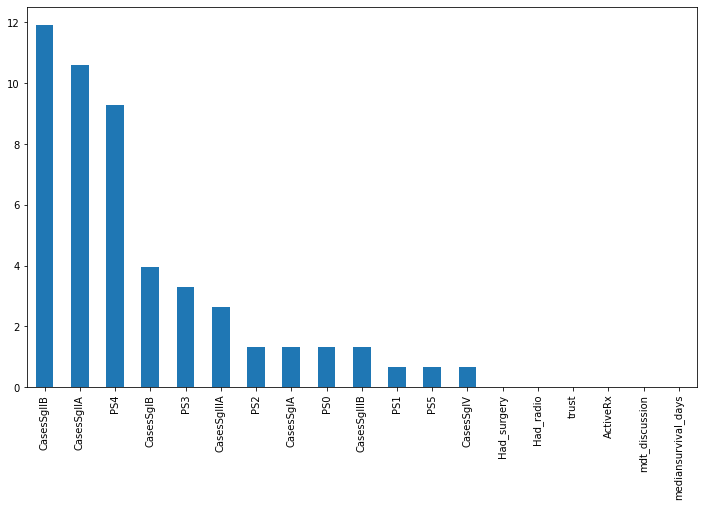

In [35]:
#percentage missingness

plt.rcParams['figure.figsize']=(12,7)
plt.figure()
missing_data['percentage'].plot.bar()
plt.show()

In [36]:
#Calculate missingness in the second dataframe

df2_missing = df2.isnull().sum().sort_values(ascending=False)
df2_nulls = df2.isnull().sum()
df2_sample = df2.isnull().count()
df2_percent_missing = 100*(df2_nulls/df2_sample).sort_values(ascending=False)
missing_data_df2 = pd.concat([df2_missing, df2_percent_missing], axis=1, keys=['missing', 'percentage'])

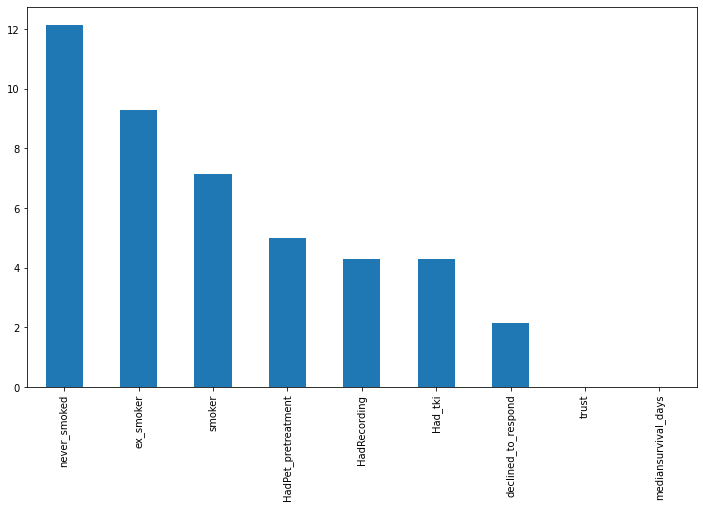

In [37]:
#Percentage missingness

plt.figure()
missing_data_df2['percentage'].plot.bar()
plt.show()

In [38]:
#since the missing are not too many, fill them with zeros 
df1=df1.fillna(0)
df2 =df2.fillna(0)

## check for and remove outliers

## dataframe *one>

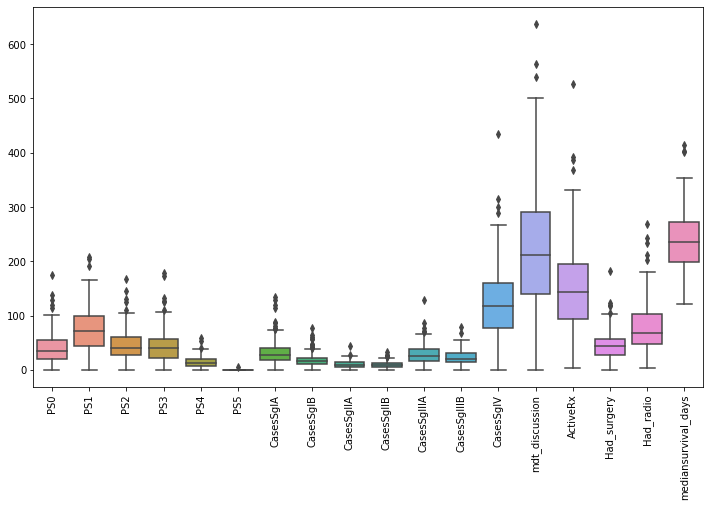

In [39]:
#show outliers using boxplot

plt.figure()
seaborn.boxplot(data=df1)
plt.xticks(rotation=90)
plt.show()

In [40]:
df_1 = df1.copy()
df_1.drop('trust', axis=1, inplace=True)

In [41]:
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    ls = df.index[(df[ft] < lower) | (df[ft] > upper)]
    
    return ls

In [42]:
index_list= []
for col in df_1.columns:
    index_list.extend(outliers(df_1, col))

In [43]:
def remove(df, index_list):  
    index_list = sorted(set(index_list))
    df = df.drop(index_list)
    return df

In [44]:
df_1 = remove(df_1, index_list)

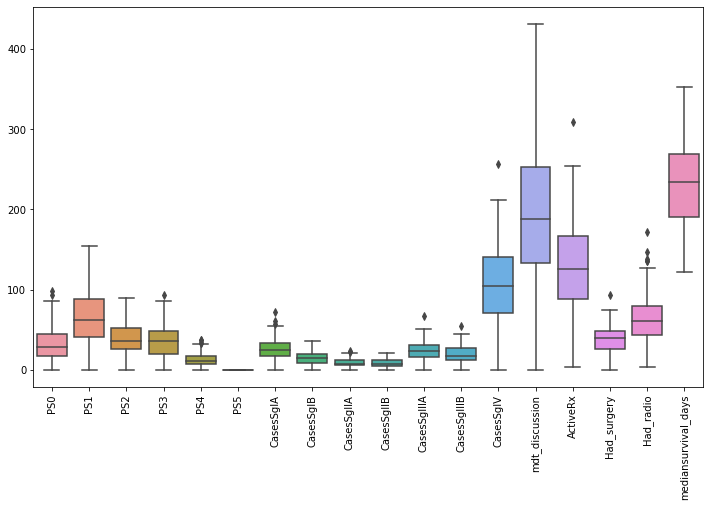

In [45]:
plt.figure()
seaborn.boxplot(data=df_1)
plt.xticks(rotation=90)
plt.show()

<Figure size 864x504 with 0 Axes>

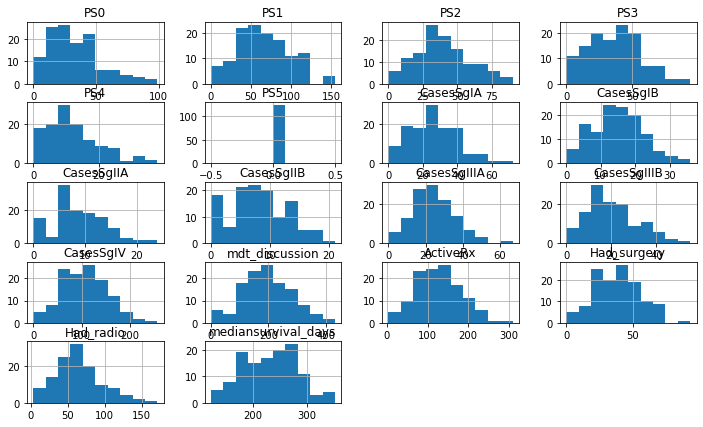

In [46]:
#The cleaned data is mostly has a bell shaped distribution
plt.figure()
df_1.hist()
plt.show()

## dataframe *two>

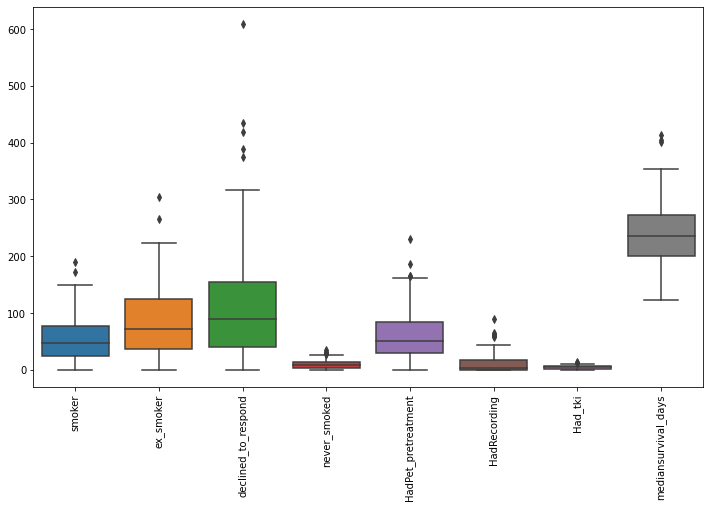

In [47]:
plt.figure()
seaborn.boxplot(data=df2)
plt.xticks(rotation=90)
plt.show()

In [48]:
df_2 = df2.copy()
df_2.drop('trust', axis=1, inplace=True)

index_list2= []
for col in df_2.columns:
    index_list2.extend(outliers(df_2, col))

In [49]:
df_2 = remove(df_2, index_list2)

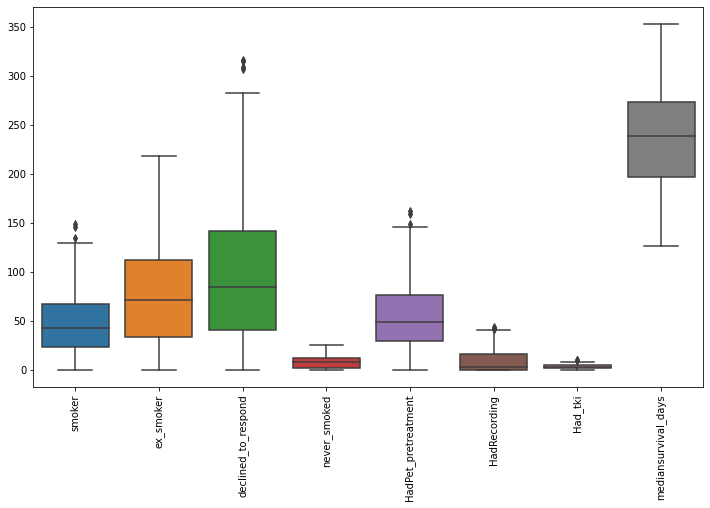

In [50]:
plt.figure()
seaborn.boxplot(data=df_2)
plt.xticks(rotation=90)
plt.show()

<Figure size 864x504 with 0 Axes>

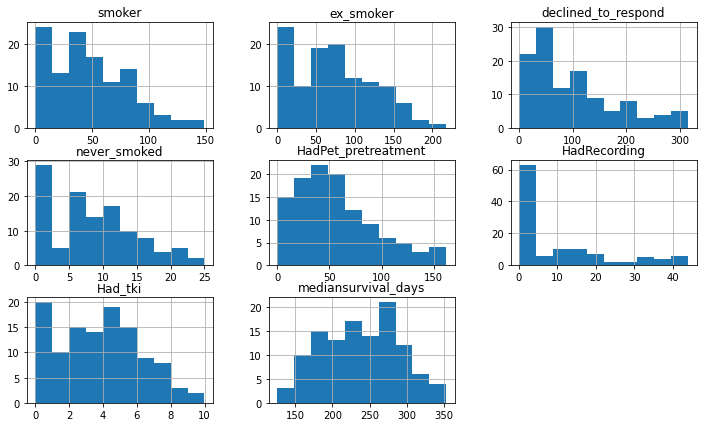

In [51]:
#The cleaned data mostly has a skewed distribution in the second dataset even after removing outliers

plt.figure()
df_2.hist()
plt.show()

# normalise data and check for correlation

In [52]:
from sklearn.preprocessing import normalize, scale

## dataframe *one>

In [53]:
df = np.array(df_1)
df

array([[ 29.    ,  55.    ,  36.    , ...,  34.272 ,  65.6712, 216.5   ],
       [ 12.    ,  41.    ,  30.    , ...,  25.06  ,  41.482 , 181.5   ],
       [ 17.    ,  18.    ,  10.    , ...,   8.96  ,   6.02  , 214.    ],
       ...,
       [ 63.    , 115.    ,  66.    , ...,  69.552 ,  98.4768, 241.    ],
       [ 74.    ,  87.    ,  37.    , ...,  55.428 ,  69.3744, 233.    ],
       [ 71.    ,  76.    ,  46.    , ...,  54.855 ,  78.1485, 277.    ]])

In [54]:
df1_scaled = scale(df, axis = 0)
df1_scaled

array([[-0.19449935, -0.33292368, -0.15797568, ..., -0.27066498,
         0.04056537, -0.2875648 ],
       [-1.00478519, -0.77043731, -0.4601194 , ..., -0.80606669,
        -0.72057035, -0.9892973 ],
       [-0.76646583, -1.4892097 , -1.46726514, ..., -1.74179917,
        -1.83641524, -0.33768855],
       ...,
       [ 1.42607233,  1.54213474,  1.35274292, ...,  1.77980967,
         1.07282415,  0.20364794],
       [ 1.95037493,  0.66710748, -0.1076184 , ...,  0.95892237,
         0.15709001,  0.04325195],
       [ 1.80738331,  0.32334677,  0.34559719, ...,  0.9256196 ,
         0.43317525,  0.92542994]])

In [55]:
print(np.var(df1_scaled[:,0]))
print(np.mean(df1_scaled[:,0]))

1.0
9.848752637803808e-17


In [56]:
df1_scaled = pd.DataFrame(df1_scaled, columns = df_1.columns)
df1_scaled.head(3)

,PS0,PS1,PS2,PS3,PS4,PS5,CasesSgIA,CasesSgIB,CasesSgIIA,CasesSgIIB,CasesSgIIIA,CasesSgIIIB,CasesSgIV,mdt_discussion,ActiveRx,Had_surgery,Had_radio,mediansurvival_days
0,-0.194499,-0.332924,-0.157976,-0.157856,-0.130137,0.0,-0.532894,-0.894664,0.464364,-0.226137,-0.457002,0.808926,-0.668918,-0.301703,-0.347798,-0.270665,0.040565,-0.287565
1,-1.004785,-0.770437,-0.460119,0.688861,-0.597878,0.0,-0.900816,0.163151,-1.697387,-0.432321,-1.404344,0.167109,-0.690121,-0.614913,-1.065107,-0.806067,-0.720570,-0.989297
2,-0.766466,-1.489210,-1.467265,-1.253606,-1.416424,0.0,-1.930998,-1.159118,-1.697387,-1.669424,-1.576588,-1.208214,-1.623050,-1.589343,-1.800189,-1.741799,-1.836415,-0.337689


<AxesSubplot:>

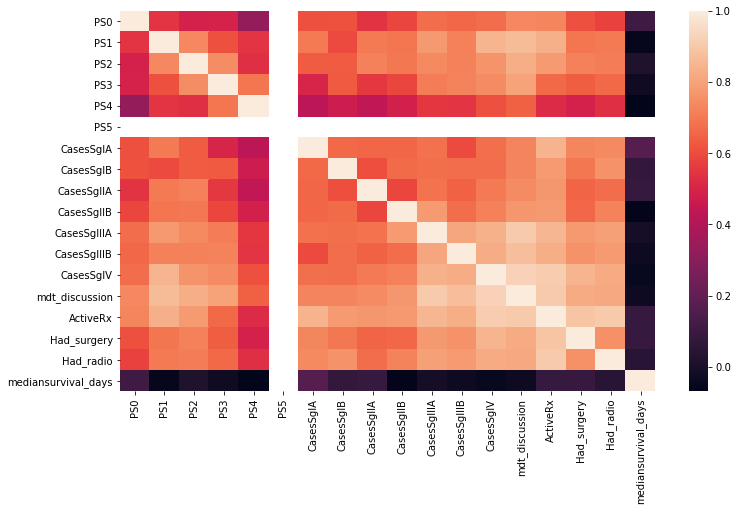

In [57]:
seaborn.heatmap(df1_scaled.corr())

<AxesSubplot:>

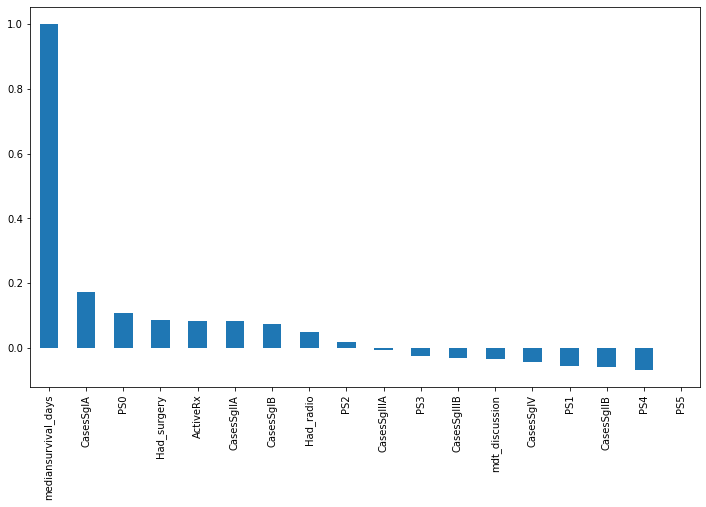

In [58]:
df1_scaled.corr()['mediansurvival_days'].sort_values(ascending = False).plot(kind='bar')

## dataframe *two>

In [59]:
df_two = np.array(df_2)
df_two[:2]

array([[  9.    ,  13.    ,   7.    ,   0.    , 146.    ,   0.    ,
          0.9982, 233.    ],
       [149.    , 218.    , 203.    ,  21.    ,  28.    ,  11.0001,
          1.0011, 181.5   ]])

In [60]:
df2_scaled = scale(df_two, axis = 0)
df2_scaled[:2]

array([[-1.12059099, -1.20683431, -1.17293451, -1.27597842,  2.31925984,
        -0.77886383, -1.08784126, -0.06187733],
       [ 2.92459173,  2.8065835 ,  1.22419523,  1.96769304, -0.74942229,
         0.06397221, -1.08666773, -1.08126113]])

In [61]:
print(np.mean(df2_scaled[:,0]))
print(np.var(df2_scaled[:,0]))

6.178632484870436e-17
0.9999999999999998


In [62]:
df2_scaled = pd.DataFrame(df2_scaled, columns = df_2.columns)
df2_scaled.head(3)

,smoker,ex_smoker,declined_to_respond,never_smoked,HadPet_pretreatment,HadRecording,Had_tki,mediansurvival_days
0,-1.120591,-1.206834,-1.172935,-1.275978,2.319260,-0.778864,-1.087841,-0.061877
1,2.924592,2.806583,1.224195,1.967693,-0.749422,0.063972,-1.086668,-1.081261
2,-0.109295,-0.462884,0.612683,0.732009,-0.983474,-0.778864,0.531030,-1.546417


<AxesSubplot:>

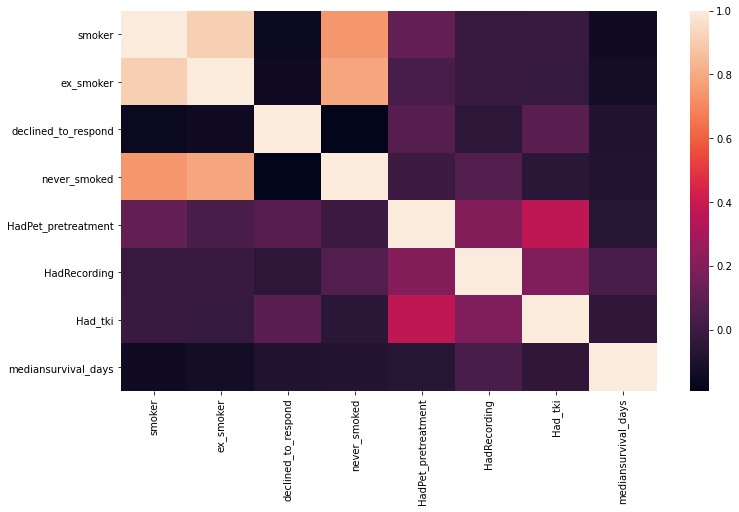

In [63]:
seaborn.heatmap(df2_scaled.corr())

<AxesSubplot:>

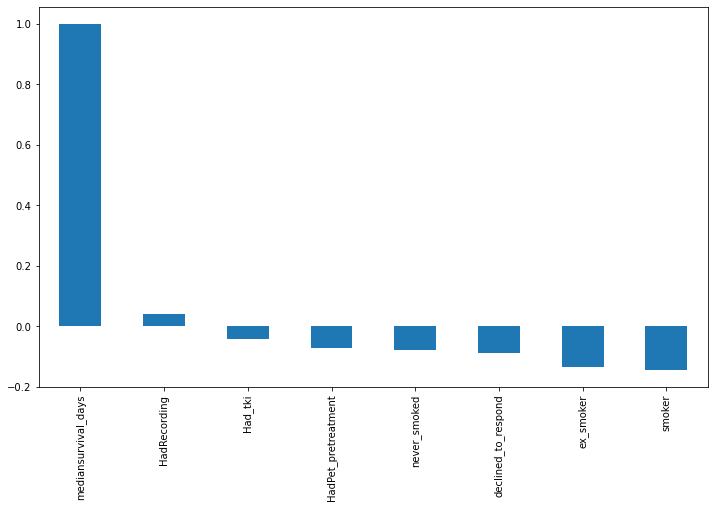

In [64]:
df2_scaled.corr()['mediansurvival_days'].sort_values(ascending=False).plot.bar()

# check Pearson correlation for the most visibly correlated columns

## dataframe *one>

In [65]:
from scipy.stats import pearsonr

In [66]:
stat, p = pearsonr(df1_scaled['mediansurvival_days'], df1_scaled['CasesSgIA'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.172, p=0.057
Probably dependent


In [67]:
stat, p = pearsonr(df1_scaled['mediansurvival_days'], df1_scaled['PS0'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.107, p=0.238
Probably independent


In [68]:
stat, p = pearsonr(df1_scaled['mediansurvival_days'], df1_scaled['ActiveRx'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.083, p=0.357
Probably independent


In [69]:
stat, p = pearsonr(df1_scaled['mediansurvival_days'], df1_scaled['CasesSgIB'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.073, p=0.417
Probably independent


In [70]:
stat, p = pearsonr(df1_scaled['mediansurvival_days'], df1_scaled['Had_surgery'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.086, p=0.341
Probably independent


In [71]:
stat, p = pearsonr(df1_scaled['mediansurvival_days'], df1_scaled['Had_radio'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.048, p=0.600
Probably independent


In [72]:
stat, p = pearsonr(df1_scaled['mediansurvival_days'], df1_scaled['CasesSgIIB'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=-0.061, p=0.502
Probably independent


## Dataframe two

In [73]:
stat, p = pearsonr(df2_scaled['mediansurvival_days'], df2_scaled['HadRecording'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.039, p=0.676
Probably independent


In [74]:
stat, p = pearsonr(df2_scaled['mediansurvival_days'], df2_scaled['HadRecording'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.039, p=0.676
Probably independent


In [75]:
stat, p = pearsonr(df2_scaled['mediansurvival_days'], df2_scaled['HadPet_pretreatment'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=-0.071, p=0.448
Probably independent


In [76]:
stat, p = pearsonr(df2_scaled['mediansurvival_days'], df2_scaled['never_smoked'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=-0.078, p=0.410
Probably independent


In [77]:
stat, p = pearsonr(df2_scaled['mediansurvival_days'], df2_scaled['ex_smoker'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=-0.135, p=0.151
Probably independent


In [78]:
stat, p = pearsonr(df2_scaled['mediansurvival_days'], df2_scaled['smoker'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.06:
    print('Probably independent')
else:
    print('Probably dependent')

stat=-0.145, p=0.123
Probably independent


# Perform multivariate linear regression to further confirm relationship

In [79]:
import statsmodels.api as sm

## Dataframe *one>

In [80]:
x = df_1.iloc[:, :-1]
y= df_1['mediansurvival_days']

x= scale(x, axis=0)
y=scale(y, axis=0)

x = np.array(x)
y = np.array(y)

In [81]:
x = sm.add_constant(x)

In [82]:
model = sm.OLS(y, x)

In [83]:
results = model.fit()

In [84]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     1.498
Date:                Tue, 15 Nov 2022   Prob (F-statistic):              0.114
Time:                        22:22:12   Log-Likelihood:                -163.42
No. Observations:                 124   AIC:                             360.8
Df Residuals:                     107   BIC:                             408.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.939e-18      0.087  -7.94e-17      1.0

In [117]:
cols = df_1.iloc[:,:-1].columns
print(cols)
print([df_1.columns.get_loc(c) for c in cols if c in df_1.iloc[:,:-1]])

Index(['PS0', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'CasesSgIA', 'CasesSgIB',
       'CasesSgIIA', 'CasesSgIIB', 'CasesSgIIIA', 'CasesSgIIIB', 'CasesSgIV',
       'mdt_discussion', 'ActiveRx', 'Had_surgery', 'Had_radio'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## dataframe *two>

In [85]:
x2= df_2.iloc[:, :-1]
y2= df_2['mediansurvival_days']

x2= scale(x2, axis=0)
y2=scale(y2, axis=0)

x2 = np.array(x2)
y2 = np.array(y2)

In [86]:
x2 = sm.add_constant(x2)

In [87]:
model2 = sm.OLS(y2, x2)

In [88]:
results2 = model2.fit()

In [89]:
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.6216
Date:                Tue, 15 Nov 2022   Prob (F-statistic):              0.737
Time:                        22:22:12   Log-Likelihood:                -160.89
No. Observations:                 115   AIC:                             337.8
Df Residuals:                     107   BIC:                             359.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.249e-16      0.095   1.32e-15      1.0

In [90]:
df_2.columns

Index(['smoker', 'ex_smoker', 'declined_to_respond', 'never_smoked',
       'HadPet_pretreatment', 'HadRecording', 'Had_tki',
       'mediansurvival_days'],
      dtype='object')

## perform clustering analysis using Kmeans

In [91]:
from sklearn.cluster import KMeans

## dataframe *one>

In [92]:
df1_scaled = scale(df1, axis=0)

In [93]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df1_scaled)

In [94]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])

In [95]:
df1['labels'] = kmeans.labels_

In [96]:
df1.groupby('labels').mean()

,PS0,PS1,PS2,PS3,PS4,PS5,CasesSgIA,CasesSgIB,CasesSgIIA,CasesSgIIB,CasesSgIIIA,CasesSgIIIB,CasesSgIV,mdt_discussion,ActiveRx,Had_surgery,Had_radio,mediansurvival_days
labels,,,,,,,,,,,,,,,,,,
0,25.969697,54.545455,31.898990,29.494949,9.818182,0.060606,22.040404,12.505051,6.969697,6.383838,19.656566,15.818182,88.585859,156.878788,107.688096,32.851323,53.275044,233.404040
1,70.000000,116.365385,73.019231,71.519231,22.826923,0.000000,54.634615,29.942308,16.769231,15.615385,48.115385,37.384615,193.826923,363.269231,242.499575,71.372212,123.961783,241.605769


In [97]:
stat, p = pearsonr(df1['mediansurvival_days'], df1['labels'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.072, p=0.381
Probably independent


## dataframe *two>

In [98]:
df2_scaled = scale(df2, axis=0)

In [99]:
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(df2_scaled)

In [100]:
kmeans2.labels_

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1])

In [101]:
df2['labels'] = kmeans2.labels_

In [102]:
df2.groupby('labels').mean()

,smoker,ex_smoker,declined_to_respond,never_smoked,HadPet_pretreatment,HadRecording,Had_tki,mediansurvival_days
labels,,,,,,,,
0,29.355556,46.744444,122.133333,5.077778,59.800153,13.022026,4.255453,245.316667
1,93.480000,144.340000,99.760000,16.980000,63.140402,10.900046,3.679534,223.200000


In [103]:
stat, p = pearsonr(df2['mediansurvival_days'], df2['labels'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=-0.192, p=0.023
Probably dependent
